# Predictive Model: Data Injection and Visualization for Dutch TTF Natural Gas Futures
This notebook demonstrates how to handle missing days in the Dutch TTF Natural Gas Futures dataset using linear interpolation, and visualizes the results. The approach leverages daily high, low, and percentage change columns for more informed interpolation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

## Load the TTF Training Data
Read the historical Dutch TTF Natural Gas Futures data and inspect the first few rows.

In [71]:
# The CSV was read as a single column due to semicolon delimiter. Let's fix that.
file_path = 'Dutch TTF Natural Gas Futures Historical Data training.csv'
df = pd.read_csv(file_path, delimiter=';')
print('Columns:', df.columns.tolist())
# Now proceed with date parsing and sorting
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
else:
    raise ValueError('Date column not found in the dataset.')

if df.index.name != 'Date':
    df = df.set_index('Date')
df.head()

Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,22.475,22.280,22.550,22.145,0.02K,2.25%
2019-01-03,22.255,22.215,22.215,22.115,0.01K,-0.98%
2019-01-04,22.930,22.845,22.955,22.810,0.04K,3.03%
2019-01-07,21.530,21.910,21.910,21.470,0.04K,-6.11%
2019-01-08,22.090,22.165,22.165,22.165,0.01K,2.60%


## Parse Dates and Sort
Convert the 'Date' column to datetime, sort the data, and set it as the index.

In [72]:
# DataFrame 'df' is already indexed by date and sorted.
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,22.475,22.280,22.550,22.145,0.02K,2.25%
2019-01-03,22.255,22.215,22.215,22.115,0.01K,-0.98%
2019-01-04,22.930,22.845,22.955,22.810,0.04K,3.03%
2019-01-07,21.530,21.910,21.910,21.470,0.04K,-6.11%
2019-01-08,22.090,22.165,22.165,22.165,0.01K,2.60%


## Reindex to Include All Calendar Days
Reindex the DataFrame to include all days in the date range, so missing days are visible and can be interpolated.

In [73]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_full = df.reindex(full_range)
df_full.head(10)

,Price,Open,High,Low,Vol.,Change %
2019-01-02,22.475,22.280,22.550,22.145,0.02K,2.25%
2019-01-03,22.255,22.215,22.215,22.115,0.01K,-0.98%
2019-01-04,22.930,22.845,22.955,22.810,0.04K,3.03%
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,21.530,21.910,21.910,21.470,0.04K,-6.11%
2019-01-08,22.090,22.165,22.165,22.165,0.01K,2.60%
2019-01-09,21.720,22.515,22.515,21.745,0.02K,-1.67%
2019-01-10,21.675,21.705,21.705,21.705,0.01K,-0.21%
2019-01-11,22.255,22.390,22.390,22.085,0.08K,2.68%


## Linear Interpolation for Missing Values
Interpolate missing values for each relevant column (Price, Open, High, Low, Vol., Change %) using linear interpolation.

In [74]:
for col in ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']:
    if col in df_full.columns:
        df_full[col] = df_full[col].interpolate(method='linear')
df_full.head(10)

,Price,Open,High,Low,Vol.,Change %
2019-01-02,22.475000,22.280000,22.550000,22.145000,0.02K,2.25%
2019-01-03,22.255000,22.215000,22.215000,22.115000,0.01K,-0.98%
2019-01-04,22.930000,22.845000,22.955000,22.810000,0.04K,3.03%
2019-01-05,22.463333,22.533333,22.606667,22.363333,NaN,NaN
2019-01-06,21.996667,22.221667,22.258333,21.916667,NaN,NaN
2019-01-07,21.530000,21.910000,21.910000,21.470000,0.04K,-6.11%
2019-01-08,22.090000,22.165000,22.165000,22.165000,0.01K,2.60%
2019-01-09,21.720000,22.515000,22.515000,21.745000,0.02K,-1.67%
2019-01-10,21.675000,21.705000,21.705000,21.705000,0.01K,-0.21%
2019-01-11,22.255000,22.390000,22.390000,22.085000,0.08K,2.68%


## Visualize Interpolated Price
Plot the interpolated price series alongside the original data to visualize the effect of interpolation.

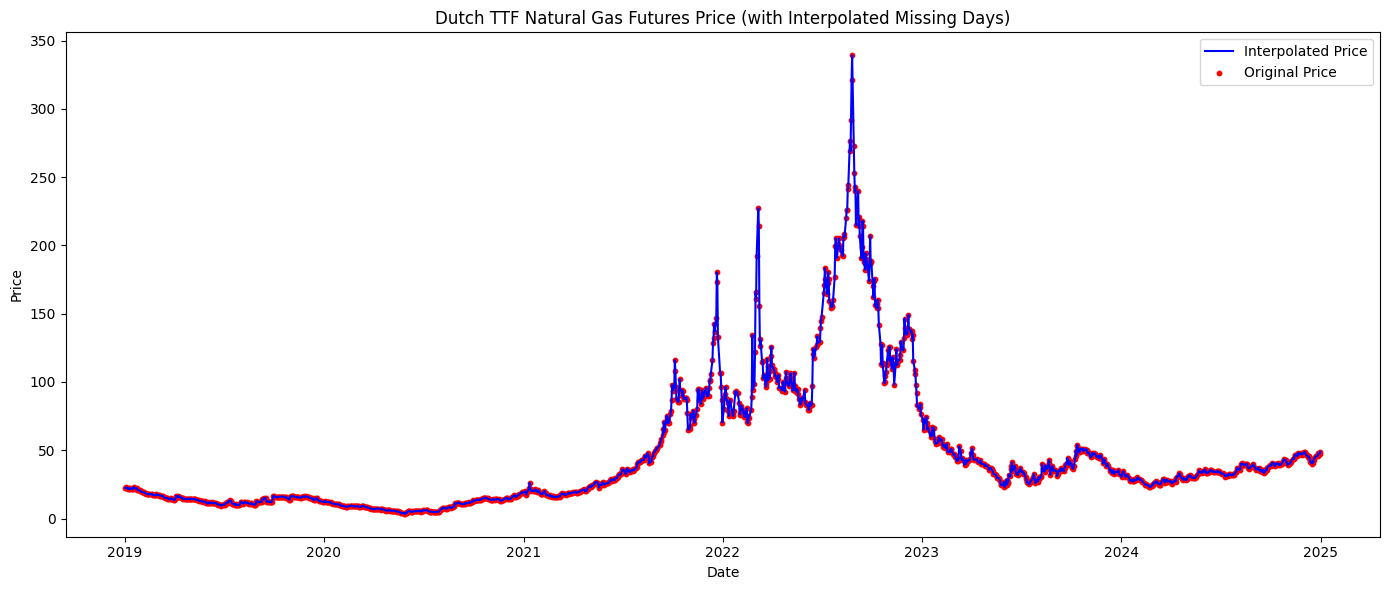

In [64]:
plt.figure(figsize=(14, 6))
plt.plot(df_full.index, df_full['Price'], label='Interpolated Price', color='blue')
plt.scatter(df.index, df['Price'], color='red', s=10, label='Original Price')
plt.title('Dutch TTF Natural Gas Futures Price (with Interpolated Missing Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

## Predicting Netherlands Electricity Prices for 2025 Using Gas Prices (SARIMAX)
We will use the synthetic hourly gas prices as an exogenous variable to predict hourly electricity prices in the Netherlands for the period 2025-01-01 to 2025-05-12 20:00 using the SARIMAX model. The model will be trained on all available data up to 2025-01-01.

In [75]:
# Load the Netherlands electricity prices (hourly)
elec_path = 'Netherlands.csv'
df_elec = pd.read_csv(elec_path, delimiter=';')

# Parse datetime and set as index
if 'Datetime (UTC)' in df_elec.columns:
    date_col = 'Datetime (UTC)'
else:
    possible_date_cols = [col for col in df_elec.columns if 'date' in col.lower() or 'time' in col.lower()]
    date_col = possible_date_cols[0] if possible_date_cols else df_elec.columns[0]
df_elec[date_col] = pd.to_datetime(df_elec[date_col], dayfirst=True, errors='coerce')
df_elec = df_elec.set_index(date_col)
df_elec = df_elec.sort_index()

# Ensure gas prices have the same index name and type
if 'Datetime (UTC)' not in df_full.columns:
    df_full['Datetime (UTC)'] = df_full.index
    df_full = df_full.set_index('Datetime (UTC)')

# Align both to hourly, remove tz, and floor to hour
for df_ in [df_elec, df_full]:
    df_.index = pd.to_datetime(df_.index).tz_localize(None).floor('H')

# Define training and prediction periods
train_end = pd.Timestamp('2024-12-31 00:00:00')  # Use last available gas price date
predict_end = pd.Timestamp('2025-05-12 20:00:00')

# Training data: up to (and including) 2024-12-31
train_idx = df_elec.index[(df_elec.index <= train_end) & (df_elec.index >= df_full.index.min())]
train_idx = train_idx.intersection(df_full.index)
endog_train = df_elec.loc[train_idx].iloc[:, 0]
exog_train = df_full.loc[train_idx]['Price']

# Prediction period: 2025-01-01 to 2025-05-12 20:00
pred_idx = df_elec.index[(df_elec.index > train_end) & (df_elec.index <= predict_end)]
pred_idx = pred_idx.intersection(df_full.index)
exog_pred = df_full.loc[pred_idx]['Price']

print('Training period:', train_idx.min(), 'to', train_idx.max())
print('Prediction period:', pred_idx.min(), 'to', pred_idx.max())
print('Train shape:', endog_train.shape, exog_train.shape)
print('Pred shape:', exog_pred.shape)

Training period: 2019-01-02 00:00:00 to 2024-12-31 00:00:00
Prediction period: NaT to NaT
Train shape: (2191,) (2191,)
Pred shape: (0,)


In [76]:
# SARIMAX modeling and prediction
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Use the actual electricity price as the endogenous variable
endog_train_numeric = df_elec.loc[train_idx]["Price (EUR/MWhe)"]

# Fit SARIMAX on training data
model = SARIMAX(endog_train_numeric, exog=exog_train, order=(1,1,1), seasonal_order=(1,0,1,24))
results = model.fit(disp=False)

# Forecast for the prediction period, only if pred_idx is not empty
if len(pred_idx) > 0:
    pred = results.predict(start=pred_idx[0], end=pred_idx[-1], exog=exog_pred)

    # Plot results
    plt.figure(figsize=(16,6))
    plt.plot(endog_train_numeric.index, endog_train_numeric, label='Actual Electricity Price (Train)', color='black', alpha=0.7)
    plt.plot(pred.index, pred, label='SARIMAX Prediction (2025)', color='blue', alpha=0.7)
    actual_2025 = df_elec.loc[pred_idx]["Price (EUR/MWhe)"]
    if len(actual_2025) > 0:
        plt.plot(actual_2025.index, actual_2025, label='Actual Electricity Price (2025)', color='red', alpha=0.5)
    plt.title('SARIMAX Prediction of Netherlands Electricity Prices (2025, up to 12/05/2025 20:00)')
    plt.xlabel('Datetime')
    plt.ylabel('Electricity Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Warning: pred_idx is empty. No prediction or plot will be generated.")

**Note:** For best results, tune the SARIMAX order and seasonal parameters, and ensure the electricity price column is correctly selected. This workflow uses gas prices as an exogenous regressor and predicts electricity prices for the specified 2025 period.

In [77]:
# Export the TTF data with hourly prices to a new CSV file
# If you want the synthetic hourly prices, use df_hourly_synth if it exists, otherwise use df_full.resample('H').ffill()
try:
    df_hourly_out = df_hourly_synth.copy()
except NameError:
    df_hourly_out = df_full.resample('H').ffill()

# Save to CSV
output_path = 'TTF_Hourly_Prices.csv'
df_hourly_out.to_csv(output_path)
print(f"Hourly TTF prices exported to {output_path}")

Hourly TTF prices exported to TTF_Hourly_Prices.csv


## Use the Exported Hourly TTF CSV for Modeling
Now we will use the exported 'TTF_Hourly_Prices.csv' as the gas price input for the SARIMAX model, ensuring the workflow is reproducible and modular.

In [78]:
# Load the hourly TTF prices from the exported CSV
hourly_gas_path = 'TTF_Hourly_Prices.csv'
df_hourly_gas = pd.read_csv(hourly_gas_path, index_col=0, parse_dates=True)

# Ensure the index is named 'Datetime (UTC)' for alignment
if df_hourly_gas.index.name != 'Datetime (UTC)':
    df_hourly_gas.index.name = 'Datetime (UTC)'

# Align both to hourly, remove tz, and floor to hour
for df_ in [df_elec, df_hourly_gas]:
    df_.index = pd.to_datetime(df_.index).tz_localize(None).floor('H')

# Define training and prediction periods
train_end = pd.Timestamp('2024-12-31 00:00:00')
predict_end = pd.Timestamp('2025-05-12 20:00:00')

# Training data: up to (and including) 2024-12-31
train_idx = df_elec.index[(df_elec.index <= train_end) & (df_elec.index >= df_hourly_gas.index.min())]
train_idx = train_idx.intersection(df_hourly_gas.index)
endog_train = df_elec.loc[train_idx].iloc[:, 0]
exog_train = df_hourly_gas.loc[train_idx]['Price']

# Prediction period: 2025-01-01 to 2025-05-12 20:00
pred_idx = df_elec.index[(df_elec.index > train_end) & (df_elec.index <= predict_end)]
pred_idx = pred_idx.intersection(df_hourly_gas.index)
exog_pred = df_hourly_gas.loc[pred_idx]['Price']

print('Training period:', train_idx.min(), 'to', train_idx.max())
print('Prediction period:', pred_idx.min(), 'to', pred_idx.max())
print('Train shape:', endog_train.shape, exog_train.shape)
print('Pred shape:', exog_pred.shape)

Training period: 2019-01-02 00:00:00 to 2024-12-31 00:00:00
Prediction period: 2024-12-31 01:00:00 to 2024-12-31 23:00:00
Train shape: (52561,) (52562,)
Pred shape: (23,)


In [81]:
# SARIMAX modeling and prediction using the loaded hourly gas prices
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Align indices of endog and exog for SARIMAX
aligned_idx = endog_train_numeric.index.intersection(exog_train.index)
endog_aligned = endog_train_numeric.loc[aligned_idx]
exog_aligned = exog_train.loc[aligned_idx]

model = SARIMAX(endog_aligned, exog=exog_aligned, order=(1,1,1), seasonal_order=(1,0,1,24))
results = model.fit(disp=False)

if len(pred_idx) > 0:
    pred = results.predict(start=pred_idx[0], end=pred_idx[-1], exog=exog_pred)
    plt.figure(figsize=(16,6))
    plt.plot(endog_aligned.index, endog_aligned, label='Actual Electricity Price (Train)', color='black', alpha=0.7)
    plt.plot(pred.index, pred, label='SARIMAX Prediction (2025)', color='blue', alpha=0.7)
    actual_2025 = df_elec.loc[pred_idx]["Price (EUR/MWhe)"]
    if len(actual_2025) > 0:
        plt.plot(actual_2025.index, actual_2025, label='Actual Electricity Price (2025)', color='red', alpha=0.5)
    plt.title('SARIMAX Prediction of Netherlands Electricity Prices (2025, up to 12/05/2025 20:00)')
    plt.xlabel('Datetime')
    plt.ylabel('Electricity Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Warning: pred_idx is empty. No prediction or plot will be generated.")

ValueError: The indices for endog and exog are not aligned

**Note:** This workflow now uses the exported hourly TTF gas prices CSV for modeling, making it easy to update or swap the gas price input as needed.